# Data analysis

In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Import custom utils
from utils.data import *
from utils.metrics import *

In [3]:
# Read training data frame, ignore duplicate rows
df = pd.read_csv('../data/train.csv').drop_duplicates()
df.shape

(114765, 13)

In [4]:
# Explore feature degrees of freedom
dofs = {colname: df[colname].unique().size for colname in sorted(df.columns)}
dofs

{'action_recommendation_category': 6,
 'action_recommendation_id': 295,
 'action_recommendation_type': 3,
 'case_id': 73945,
 'completion_date': 466,
 'equipment_area': 1285,
 'equipment_category': 20,
 'equipment_id': 30000,
 'feedback': 2,
 'floors_category': 8,
 'load_category': 8,
 'speed_category': 8,
 'usage_type': 13}

<BarContainer object of 295 artists>

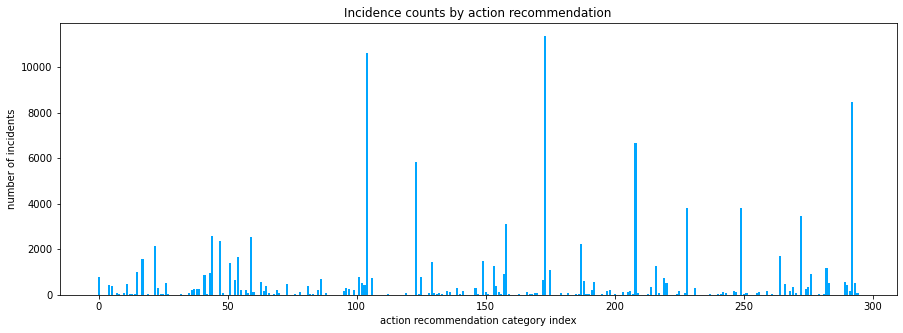

In [5]:
# Plot incidence counts for each action recommendation. This allows us to find out if there
# are specific instances of action recommendation ids that are more common (as indeed is
# highlighted by below barplot)
action_recommendation_groups = df.groupby('action_recommendation_id').size()
action_recommendation_index = np.arange(len(action_recommendation_groups.index))
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Incidence counts by action recommendation')
ax.set_ylabel('number of incidents')
ax.set_xlabel('action recommendation category index')
ax.bar(action_recommendation_index, action_recommendation_groups.values, color='#00a6ff')

In [6]:
# Group dataframe rows by false positives and true positives to compute baselines (for
# simply guessing that every action recommendation is valid) in terms of f2 score and accuracy
df_fp = df[df.feedback == 0]
df_tp = df[df.feedback == 1]
baseline_label_score = f2_score(df.feedback.values, np.ones_like(df.feedback.values))
baseline_label_acc = len(df_tp) / len(df)
baseline_label_acc, baseline_label_score

(0.8772012373110268, 0.9727646762121391)

In [7]:
# Group by select features and compute accuracy metrics for each group. This allows us to
# find out if there are specific value groups in the categorical features that perform better
# than the average
group_names = [
    'action_recommendation_id',
    'action_recommendation_category',
    'equipment_category',
    'usage_type'
]
# This function computes the metrics (accuracy) for each group
groups = compute_group_metrics(df, group_names, label_name='feedback')
groups.head()

,,,,total_count,tp_count,fp_count,accuracy
action_recommendation_id,action_recommendation_category,equipment_category,usage_type,,,,
ar00000209,arc02,tp002,ut011,2858.0,2034.0,824,0.711686
ar00000293,arc02,tp002,ut011,3613.0,2994.0,619,0.828674
ar00000174,arc03,tp006,ut007,1497.0,1039.0,458,0.694055
ar00000048,arc02,tp002,ut011,1034.0,670.0,364,0.647969
ar00000293,arc02,tp007,ut011,1311.0,1019.0,292,0.777269


In [8]:
%%time
# Using the computed accuracy groups, find the group id for each row. This group id will be
# assigned to the dataframe
group_ids = compute_group_index(
    df,
    groups,
    metric_name='accuracy',
    l_bound=0.70,
    h_bound=0.95
)

CPU times: user 1min 3s, sys: 141 ms, total: 1min 3s
Wall time: 1min 3s


In [9]:
# Apply assignment to dataframe which now contains a new column called "group_type" that indicates
# the accuracy group to which the row belongs. 0=unknown, 1=lower group, 2=middle group, 3=upper group
df = df.assign(group_type=group_ids)
df.head()

,case_id,equipment_id,completion_date,action_recommendation_id,action_recommendation_type,action_recommendation_category,equipment_area,usage_type,speed_category,load_category,floors_category,equipment_category,feedback,group_type
0,b7c775ad-4ebe-4848-9c53-37e7c5658e21,ele0000754,2018-10-03,ar00000174,art01,arc03,ga00000803,ut012,7,6,8,tp006,1,3
1,b177eefd-3946-4949-9699-0a91879350f9,ele0000789,2018-10-03,ar00000248,art02,arc03,ga00000269,ut005,4,6,2,tp001,1,0
2,fc2d568a-c53c-43ef-8871-a49ec22ab3b1,ele0001227,2018-10-03,ar00000158,art02,arc03,ga00000064,ut011,6,6,7,tp006,1,2
3,8e645922-1268-4c6b-ae6b-7b1605689cca,ele0001754,2018-10-03,ar00000105,art01,arc03,ga00000662,ut005,8,7,8,tp014,1,2
4,b44f10b1-9238-44db-8f0c-2d68e8c015a7,ele0002087,2018-10-03,ar00000148,art02,arc03,ga00001256,ut011,7,6,8,tp013,1,0


In [10]:
# Show group type counts
df.groupby('group_type').size()

group_type
0    19720
1     9999
2    67203
3    17843
dtype: int64

In [11]:
# Collect the baseline accuracy values for each group
baseline_accuracy_values = []
for group_type in range(4):
    subset = df[df.group_type == group_type]
    baseline_accuracy_values.append(subset[subset.feedback == 1].size / subset.size)
    print(f'Group {group_type} baseline accuracy:', baseline_accuracy_values[-1])

Group 0 baseline accuracy: 0.9829614604462474
Group 1 baseline accuracy: 0.5963596359635963
Group 2 baseline accuracy: 0.8635923991488476
Group 3 baseline accuracy: 0.968951409516337


In [12]:
# Save as new dataset, will be used for selective training for each group
df.to_csv('../data/train-aug.csv', encoding='utf-8', index=False)

# Test data

We apply the same group augmentation procedure to test data to help with model selection in the submission phase.

In [13]:
# Read test dataset
df_test = pd.read_csv('../data/test.csv')
df_test.shape

(29428, 12)

In [14]:
%%time
# Apply group ids
group_ids_test = compute_group_index(
    df_test,
    groups,
    metric_name='accuracy',
    l_bound=0.70,
    h_bound=0.95
)

CPU times: user 16.3 s, sys: 23.7 ms, total: 16.3 s
Wall time: 16.3 s


In [15]:
# Show group type counts to confirm similar statistics with training data
df_test = df_test.assign(group_type=group_ids_test)
df_test.groupby('group_type').size()

group_type
0     5863
1     2666
2    16546
3     4353
dtype: int64

In [16]:
# Save as new dataset
df_test.to_csv('../data/test-aug.csv', encoding='utf-8', index=False)

# Visualization

This section explores some advanced data properties, including dimensionality reduction and clustering.

In [17]:
import seaborn as sns

Text(0.5, 1.0, 'Baseline by group')

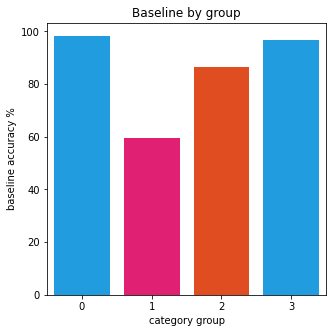

In [18]:
# Plot accuracy groups baselines as barchart
acc_df = pd.DataFrame(data={
    f'category group': np.arange(4),
    f'baseline accuracy %': np.array(baseline_accuracy_values)*100,})
plt.figure(figsize=(5, 5))
sns.barplot(
    x='category group',
    y='baseline accuracy %',
    data=acc_df,
    palette=[
        '#00a6ff',
        '#ff006f',
        '#ff3c00',
        '#00a6ff'
    ]
).set_title('Baseline by group')

In [19]:
# Create a new dataframe with select features and apply numerical encoding to categorical
# features
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
x = pd.concat([
df[[
    'action_recommendation_id',
    'action_recommendation_category',
    'equipment_area',
    'equipment_category',
    'usage_type',
    'group_type'
]].apply(lambda f: defaultdict(LabelEncoder)[f.name].fit_transform(f)),
df[[
    'floors_category',
    'load_category',
    'speed_category',
    'feedback'
]]], axis=1)
x.head()

,action_recommendation_id,action_recommendation_category,equipment_area,equipment_category,usage_type,group_type,floors_category,load_category,speed_category,feedback
0,173,2,802,6,11,3,8,6,7,1
1,247,2,268,1,4,0,2,6,4,1
2,157,2,63,6,10,2,7,6,6,1
3,104,2,661,14,4,2,8,7,8,1
4,147,2,1255,13,10,0,8,6,7,1


In [20]:
# Compute N principal components for dimensionality reduction to visualize potential
# clusters in data
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x[x.columns[:-1]].values)

In [21]:
# Pca features as new dataframe with feedback as labels
pca_df = pd.DataFrame(data={'pca_'+str(k): pca_result.T[k] for k in range(3)}).assign(y=df.feedback)
pca_df.head()

,pca_0,pca_1,pca_2,y
0,181.152459,-16.077185,1.806616,1.0
1,-353.025172,-88.811121,-3.590369,1.0
2,-557.806201,1.718796,1.580972,1.0
3,40.321090,53.288524,9.672730,1.0
4,634.214275,8.838663,8.699941,1.0


In [22]:
# Create random subsampling index
idx = np.random.permutation(pca_df.shape[0])[:5000]
idx

array([ 62055, 110145, 110460, ...,  13838,  65762,  77781])

<AxesSubplot:xlabel='pca_2', ylabel='pca_1'>

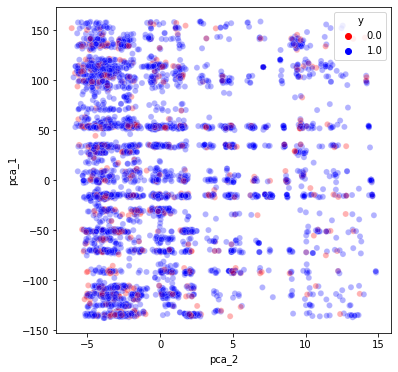

In [30]:
# Scatter 2d pca features, mild clustering, none in terms of target label
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="pca_2",
    y="pca_1",
    hue="y",
    palette=['red', 'blue'],
    data=pca_df.iloc[idx],
    legend="full",
    alpha=0.3
)

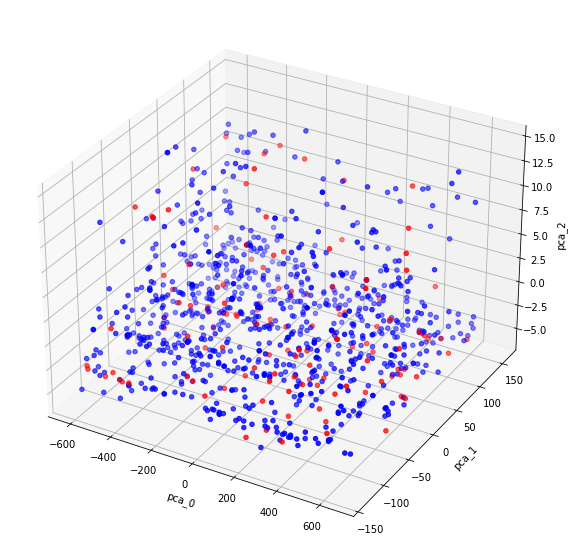

In [24]:
# Scatter 3d pca features, no clustering in terms of target label
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_df.loc[idx[:1000], :]["pca_0"], 
    ys=pca_df.loc[idx[:1000],:]["pca_1"], 
    zs=pca_df.loc[idx[:1000],:]["pca_2"], 
    c=pca_df.loc[idx[:1000], :]["y"], 
    cmap='bwr_r'
)
ax.set_xlabel('pca_0')
ax.set_ylabel('pca_1')
ax.set_zlabel('pca_2')
plt.show()

In [ ]:
%%time
# Apply t-distributed stochastic neighbour embedding to explore clustering with learned
# dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)

In [26]:
# t-SNE features as new dataframe with feedback as labels
tsne_df = pd.DataFrame(data={'tsne_'+str(k): tsne_results.T[k] for k in range(2)}).assign(y=df.feedback)
tsne_df

,tsne_0,tsne_1,y
0,-4.566646,-3.748595,1.0
1,0.106045,1.082778,1.0
2,-5.922460,-4.405671,1.0
3,8.342275,-2.228830,1.0
4,-8.109292,3.277891,1.0
...,...,...,...
114760,-6.119330,2.855923,1.0
114761,2.312336,6.599526,1.0
114762,5.569714,0.626342,1.0
114763,1.076220,-0.120274,1.0


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

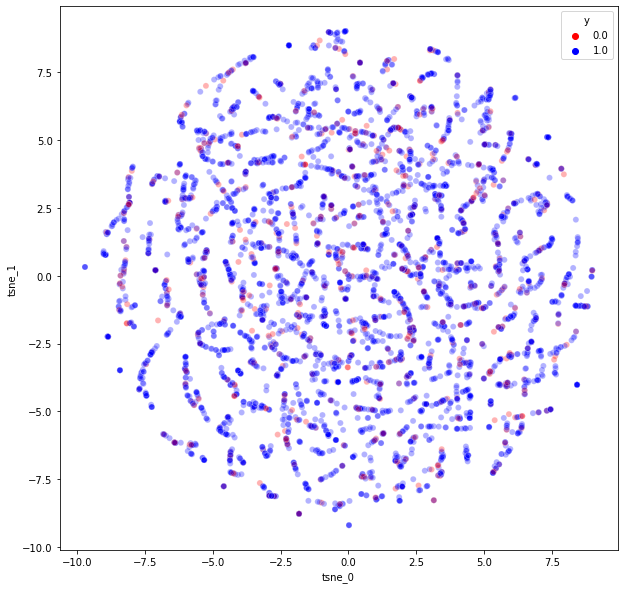

In [27]:
# Scatter 2d tsne features, mild clustering, none in terms of target label
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="tsne_0",
    y="tsne_1",
    hue="y",
    palette=['red', 'blue'],
    data=tsne_df.iloc[idx],
    legend="full",
    alpha=0.3
)